In [8]:
#neccessary imports
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
import sympy as sy
import sympy.stats
from scipy.stats import norm

In [9]:
#EXAMPLE 1: Y = U([0,1])*U([0,2])*U([0,4])
#for each example, each of these needs to be filled

def theFunc(u):
    return 8*u[0]*u[1]*u[2]

def truePDF(y):
    output = [0] * len(y)
    for j in range(len(y)):
        if y[j] > 8 or y[j] < 0:
            output[j] = 0
        else:
            output[j] = (1/16) * (np.log(y[j] / 8))**2
    return output

def conditionalDensity1(y, x2, x3):
    test = y / (x2*x3)
    for j in range(len(test)):
        if test[j] > 1 or test[j] < 0:
            test[j]=0
    return test / y

def conditionalDensity2(y, x1, x3):
    test = y / (x1*x3)
    for j in range(len(test)):
        if test[j] > 2 or test[j] < 0:
            test[j] = 0
    return test / (2*y)

def conditionalDensity3(y, x1, x2):
    test = y / (x1*x2)
    for j in range(len(test)):
        if test[j] > 4 or test[j] < 0:
            test[j] = 0
    return test / (4*y)

def inverseCDF1(y):
    return y

def inverseCDF2(y):
    return 2*y

def inverseCDF3(y):
    return 4*y

start, end = 0.01, 8
Q = 0.00000565787743961


    


In [13]:
#EXAMPLE 2: Y = U([0,1]) + U([0,2]) + U([0,4])
#for each example, each of needs needs to be filled

def theFunc(u):
    return u[0] + 2*u[1] + 4*u[2]

def truePDF(y):
    n = len(y)
    output = [0] * n
    for i in range(n):
        if y[i] < 1 and y[i] > 0:
            output[i] = (1 / 16) * y[i]**2
        elif y[i] < 2 and y[i] > 1:
            output[i] = (1 / 16) + (1 / 8) * (y[i] - 1)
        elif y[i] < 3 and y[i] > 2:
            output[i] = (3 / 16) + (3 / 8) * (y[i] - 2) - (1 / 16) * (y[i]**2 - 4)
        elif y[i] < 4 and y[i] > 3:
            output[i] = 1/4
        elif y[i] < 5 and y[i] > 4:
            output[i] = (3 / 16) + (1 / 16) * (1 - (y[i] - 4)**2)
        elif y[i] < 6 and y[i] > 5:
            output[i] = (1 / 16) + (1 / 8) * (6 - y[i])
        elif y[i] < 7 and y[i] > 6:
            output[i] = (3 / 8) * (7 - y[i]) - (1 / 16) *(9 - (y[i] - 4)**2)
        else:
            output[i] = 0
    return output

def conditionalDensity1(y, x2, x3):
    test = y - x2 - x3
    for j in range(len(test)):
        if test[j] > 0 and test[j] < 1:
            test[j] = 1
        else:
            test[j] = 0
    return test

def conditionalDensity2(y, x1, x3):
    test = y - x1 - x3
    for j in range(len(test)):
        if test[j] > 0 and test[j] < 2:
            test[j] = 1/2
        else:
            test[j] = 0
    return test

def conditionalDensity3(y, x1, x2):
    test = y - x1 - x2
    for j in range(len(test)):
        if test[j] > 0 and test[j] < 4:
            test[j] = 1/4
        else:
            test[j] = 0
    return test

def inverseCDF1(y):
    return y

def inverseCDF2(y):
    return 2*y

def inverseCDF3(y):
    return 4*y

start, end = 0, 7
Q = 25.5323059457


In [10]:
#Assuming 3 variables, these don't change
def kernelDensityEstimator(y, pointSet, bandwidth): 
    n = len(pointSet)
    def gaussianKernel(z):
         return np.exp(-z**2) / math.sqrt(math.pi)
    sum = 0
    for i in range(n):
        sum += (1 / (n*bandwidth)) * gaussianKernel((y - theFunc(pointSet[i])) / bandwidth)
    return sum

def conditionalEstimator3(y, condDensity, realizations1, realizations2):
    if len(realizations1) != len(realizations2):
        raise Exception("realizations are of different size")
    else:
        output = 0
        n = len(realizations1)
        for j in range(n):
            output += condDensity(y, realizations1[j], realizations2[j]) / n
        return output


In [11]:
def getErrorofThreeVariables(pointSetType, n, method, bandwidth):
    nError = 100
    errorPoints = np.linspace(start, end, nError)

    if n <= 0:
        raise Exception("n must be a positive integer")
    
    if pointSetType == "MC":
        pointSet = qp.IIDStdUniform(3).gen_samples(n)
    elif pointSetType == "Sobol":
        pointSet = qp.Sobol(3).gen_samples(n)
    else:
        raise Exception("Currently supported pointSetTypes are MC and Sobol")
    
    if method == "KDE":
        evaluatedPoints = kernelDensityEstimator(errorPoints, pointSet, bandwidth)
    elif method == "hiding1" or method == "hiding2" or method == "hiding3":
        realizations1 = inverseCDF1(pointSet[:, 0])
        realizations2 = inverseCDF2(pointSet[:, 1])
        realizations3 = inverseCDF3(pointSet[:, 2])
        if method == "hiding1":
            evaluatedPoints = conditionalEstimator3(errorPoints, conditionalDensity1, realizations2, realizations3)
        if method == "hiding2":
            evaluatedPoints = conditionalEstimator3(errorPoints, conditionalDensity2, realizations1, realizations3)
        if method == "hiding3":
            evaluatedPoints = conditionalEstimator3(errorPoints, conditionalDensity3, realizations1, realizations2)
    else:
        raise Exception("Valid methods are KDE or hiding#")
    
    estimatedError = ((end - start) / nError) * np.sum((evaluatedPoints - truePDF(errorPoints))**2)
    return estimatedError

def averageErrorLog(pointSetType, n, method, averageAcross, bandwidth):
    sum = 0
    for i in range(averageAcross):
        sum += (1 / averageAcross) * getErrorofThreeVariables(pointSetType, n, method, bandwidth)
    return -np.log10(sum)

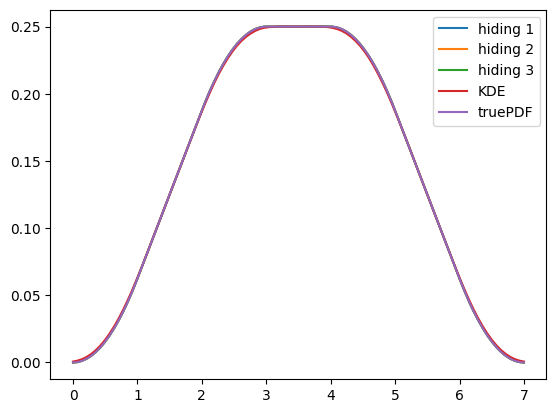

In [14]:
n = 2**16
nEval = 100
evalPoints = np.linspace(start, end, nEval)
fig, ax = plt.subplots()

sobolPoints = qp.Sobol(3).gen_samples(n)
realizations1 = inverseCDF1(sobolPoints[:, 0])
realizations2 = inverseCDF2(sobolPoints[:, 1])
realizations3 = inverseCDF3(sobolPoints[:, 2])

truePoints = truePDF(evalPoints)

hiding1Points = conditionalEstimator3(evalPoints, conditionalDensity1, realizations2, realizations3)
hiding2Points = conditionalEstimator3(evalPoints, conditionalDensity2, realizations1, realizations3)
hiding3Points = conditionalEstimator3(evalPoints, conditionalDensity3, realizations1, realizations2)

bandwidth = (Q / n) **(1/5)
KDEPoints = kernelDensityEstimator(evalPoints, sobolPoints, bandwidth)


ax.plot(evalPoints, hiding1Points, label = "hiding 1")
ax.plot(evalPoints, hiding2Points, label = "hiding 2")
ax.plot(evalPoints, hiding3Points, label = "hiding 3")
ax.plot(evalPoints, KDEPoints, label = "KDE")
ax.plot(evalPoints, truePoints, label = "truePDF")
legend = ax.legend()

In [140]:
for method in ["hiding1", "hiding2", "hiding3", "KDE"]:
    for pointSetType in ["MC", "Sobol"]:
        output = []
        for exp in range(10, 19, 2):
            n = 2**exp
            bandwidth = (Q / n) ** (1/5)
            output.append(averageErrorLog(pointSetType, n, method, 10, bandwidth))
        print(pointSetType, method, output)

MC hiding1 [3.2276027672326393, 3.6653229850795976, 4.3142567431693335, 4.961403344573826, 5.575863176932641]
Sobol hiding1 [4.399371412759576, 5.368678977658682, 5.931381256418132, 7.088675051087727, 7.772447474304518]
MC hiding2 [3.5718713730655627, 4.10908458282341, 4.750225276103817, 5.337480016593025, 5.984214932277616]
Sobol hiding2 [5.184895799096211, 5.8074795017430745, 7.105615210608205, 7.891607381057414, 8.895473368399182]
MC hiding3 [4.277577265397109, 4.898279557877436, 5.561706908044373, 6.3136972469599835, 6.809576384198683]
Sobol hiding3 [5.889824296902357, 6.860377024221059, 7.865195434878666, 8.558154528415713, 9.63539065510299]
MC KDE [3.1614665953558516, 3.515195267409838, 4.100750707179779, 4.577665380489007, 4.978040672420285]
Sobol KDE [3.826864318457108, 4.2696852874436235, 4.727941734095233, 5.192427701657736, 5.660579500759247]
